## Постановка задачи

Реализовать пайплайн:

1.      Найдите в открытых источниках исторические данные о покупках смартфонов, на kaggle например. Спрофилируйте пользователей,

2.      Найдите в открытых источниках список товаров. Как вариант - спарсите наш сайт. Кластеризуйте товары,

3.      Реализовать прогнозную модель – какой пользователь, когда и какой товар (не только смартфон видимо) хотел бы приобрести,

4.      Предложите маркетинговый инструмент – куда на вход подались бы данные прогноза, а на выход получилась бы таргетированная реклама гугл. Например https://financesonline.com/top-10-free-marketing-automation-software/. 

В качестве датасета взяты данные с соревнования Instacart Market Basket Analysis: https://www.kaggle.com/c/instacart-market-basket-analysis/data 

Набор данных для этого конкурса представляет собой реляционный набор файлов, описывающих заказы клиентов во времени. Цель конкурса - предсказать, какие продукты будут заказаны. Набор данных является анонимным и содержит выборку из более чем 3 миллионов продуктовых заказов от более чем 200 000 пользователей Instacart. Для каждого пользователя мы предоставляем от 4 до 100 их заказов с последовательностью продуктов, приобретенных в каждом заказе. Мы также предоставляем неделю и час дня, когда был размещен заказ, и относительную меру времени между заказами.

Более подробное описание данных по ссылке.

## Word2Vec для рекомендации продуктов

Word2Vec также может использоваться для запроса ближайших соседей к определенному слову, обычно так находят слова, которые по значению похожи на определенное слово, мы можем использовать это в задачах, отличных от NLP.

In [1]:
import pandas as pd
import numpy as np

In [2]:
orders = pd.read_csv("data/orders.csv")
orders.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [3]:
orders.shape

(3421083, 7)

In [4]:
train_orders = pd.read_csv("data/order_products__train.csv")
prior_orders = pd.read_csv("data/order_products__prior.csv")
products = pd.read_csv("data/products.csv").set_index('product_id')

Нам необходимо найти продукты, которые похожи друг на друга или которые обычно заказываются вместе. С точки зрения магазина это привело бы к продвижению товаров.

В подобном сценарии Word2Vec пригодится, поскольку его больше всего интересуют слова, которые объединяются в одном контексте, и мы можем использовать его для поиска товаров, которые обычно покупаются вместе, или товаров, которые похожи друг на друга. Для этого нам нужно интерпретировать каждый заказ как предложение, а каждый продукт - как слово.

In [5]:
train_orders["product_id"] = train_orders["product_id"].astype(str)
prior_orders["product_id"] = prior_orders["product_id"].astype(str)

In [6]:
train_products = train_orders.groupby("order_id").apply(lambda order: order['product_id'].tolist())
prior_products = prior_orders.groupby("order_id").apply(lambda order: order['product_id'].tolist())

In [7]:
sentences = prior_products.append(train_products)
longest = np.max(sentences.apply(len))
sentences = sentences.values

In [8]:
import gensim
model = gensim.models.Word2Vec(sentences, size=100, window=longest, min_count=2, workers=4)

C:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Поскольку в заказе нет характеристик последовательности продуктов - каждый продукт в заказе не зависит от заказов, которые были выбраны до него в корзине.

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(model.wv.syn0)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  This is separate from the ipykernel package so we can avoid doing imports until


PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Теперь модель изучила векторные представления каждого продукта (за исключением тех, которые ниже min_count), поэтому давайте посмотрим, что мы получили.

Прежде всего нам нужно спроецировать наши векторы на 2 измерения, чтобы мы могли их визуализировать. Мы делаем прогнозирование с использованием PCA.

In [14]:
vocab = list(model.wv.vocab.keys())

In [15]:
def get_batch(vocab, model, n_batches=3):
    output = list()
    for i in range(0, n_batches):
        rand_int = np.random.randint(len(vocab), size=1)[0]
        suggestions = model.most_similar(positive=[vocab[rand_int]], topn=5)
        suggest = list()
        for i in suggestions:
            suggest.append(i[0])
        output += suggest
        output.append(vocab[rand_int])
    return output

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    """From Tensorflow's tutorial."""
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(21, 21))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

Наконец, нам нужно случайным образом отобрать наши продукты и визуализировать эти продукты и их соседей.

Вот некоторые случайные результаты

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


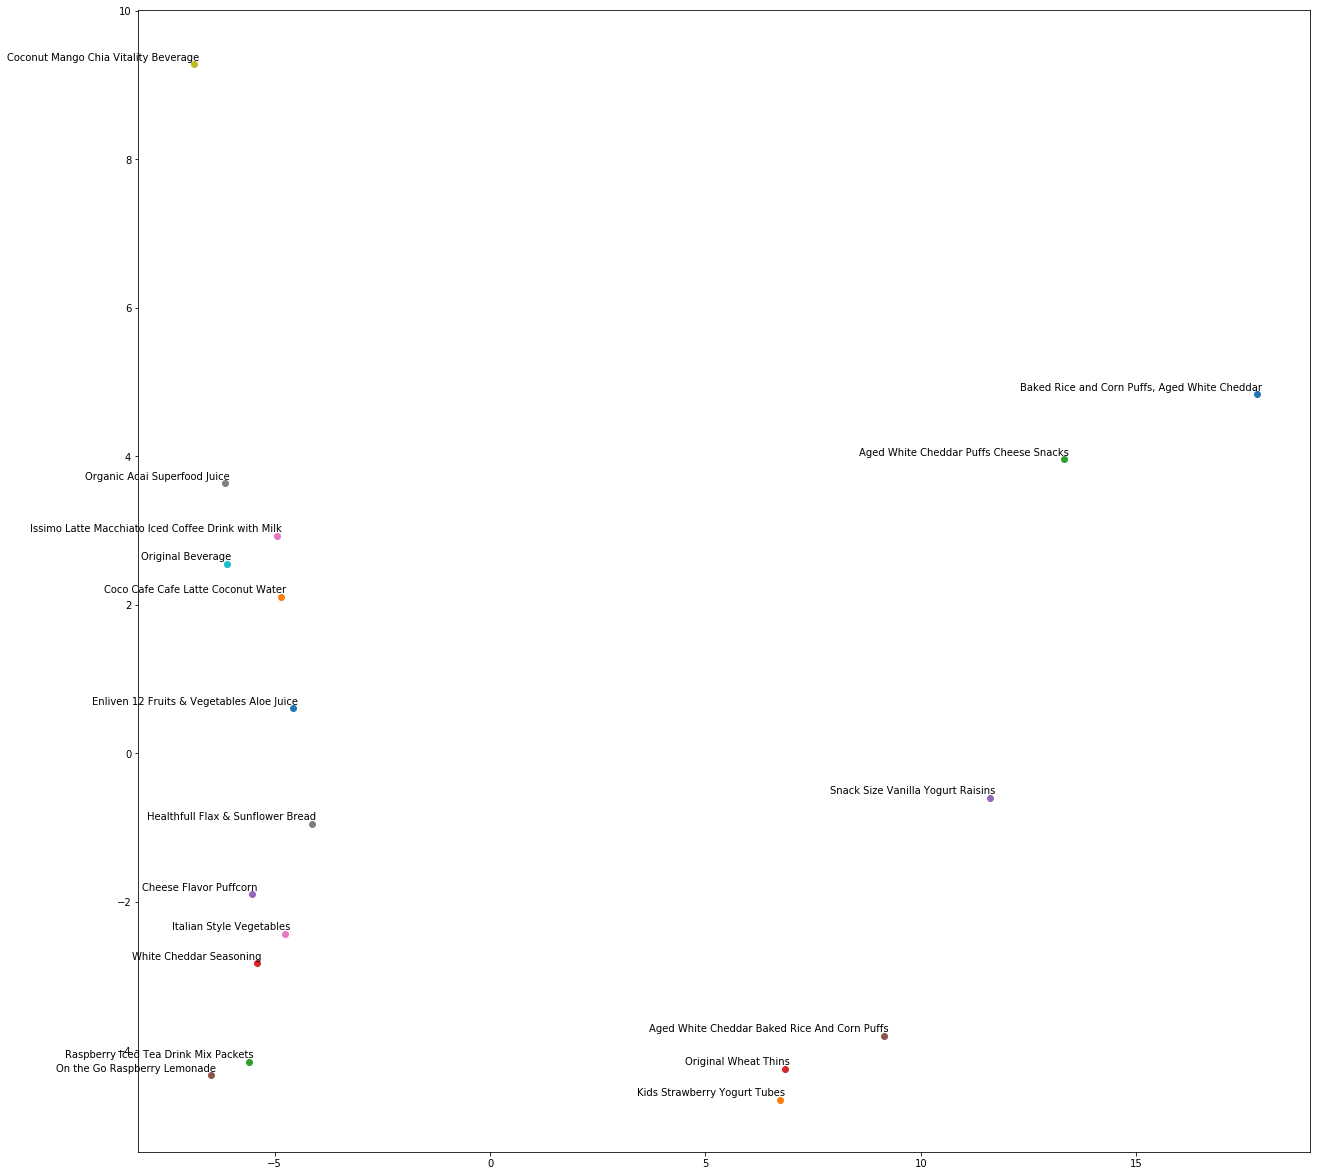

In [17]:
embeds = []
labels = []
for item in get_batch(vocab, model, n_batches=3):
    embeds.append(model[item])
    labels.append(products.loc[int(item)]['product_name'])
embeds = np.array(embeds)
embeds = pca.fit_transform(embeds)
plot_with_labels(embeds, labels)

In [25]:
products.head(5)

,product_name,aisle_id,department_id
product_id,,,
1,Chocolate Sandwich Cookies,61,19
2,All-Seasons Salt,104,13
3,Robust Golden Unsweetened Oolong Tea,94,7
4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
5,Green Chile Anytime Sauce,5,13


In [29]:
model.wv.vectors.shape

(49583, 100)

In [43]:
vocab[2]

'9327'

In [44]:
model.wv.most_similar(vocab[2])

[('35973', 0.8276666402816772),
 ('45664', 0.8214635848999023),
 ('2380', 0.7408557534217834),
 ('13212', 0.7340821027755737),
 ('37107', 0.6947633624076843),
 ('26764', 0.6867512464523315),
 ('37120', 0.6769251227378845),
 ('884', 0.6732238531112671),
 ('8203', 0.6703298091888428),
 ('14976', 0.664797306060791)]

In [48]:
model.wv.vocab['35973'].index

1990

In [49]:
model.wv.vocab['9327'].index

857

In [50]:
vocab[2]

'9327'

In [54]:
vocab[:10]

['33120',
 '28985',
 '9327',
 '45918',
 '30035',
 '17794',
 '40141',
 '1819',
 '43668',
 '33754']

In [57]:
longest

145